In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
import config
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
from tensorflow.python.ops import seq2seq as tfseq2seq

from speech2vec.models import  * 
import numpy as np

from tqdm import tqdm

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

X = mnist.train.images.reshape(55000,28,28)
X_test = mnist.test.images.reshape(10000,28,28)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)



### Learning Parameters

In [13]:
# Model Parameters
nb_epochs = 50
batch_size = 55

sample, timestep, feature = X.shape

batch_input_shape = ( batch_size, timestep, feature )

hidden_dim = 128

depth = (2,2)

dropout = 0.8

peek = False

latent_dim = 10

In [17]:
X.shape

(55000, 28, 28)

In [18]:
tf.reset_default_graph()

### Define cell

In [19]:
# Define Cell
en_cell = rnn_cell.GRUCell(hidden_dim)

en_cells = [ rnn_cell.MultiRNNCell([en_cell] * depth[0] ) ]

de_cell = rnn_cell.GRUCell(hidden_dim)

de_cells = [ rnn_cell.MultiRNNCell([de_cell] * depth[1] ) ]

### Encoder 

In [20]:
# Input placeholder
x  = tf.placeholder(tf.float32, shape=[None, timestep, feature])
keep_prob = tf.placeholder(tf.float32)

last_output = basic_encoder(en_cells, x, keep_prob)

### Predict Mean & Gaussian of Latent dimension

In [21]:
last_output_drop = tf.nn.dropout( last_output, keep_prob )
# Predict Mean & Variance of Gaussian
W_mu = tf.Variable( xavier_init(hidden_dim, latent_dim) )
b_mu = tf.Variable( tf.zeros([ latent_dim ] ) )

W_logvar = tf.Variable( xavier_init(hidden_dim,latent_dim) )
b_logvar = tf.Variable( tf.zeros([ latent_dim ] ) )

z_mean = tf.matmul(last_output_drop, W_mu) + b_mu
z_logvar = tf.matmul(last_output_drop, W_logvar) + b_logvar

### Sampling ( Reparametrization )

In [22]:
epsilon = tf.random_normal(tf.shape(z_logvar))
z = z_mean + tf.mul( tf.exp(0.5 * z_logvar), epsilon)

### Decoder

In [23]:
z_dropout = tf.nn.dropout(z, keep_prob)

W_z = tf.Variable( xavier_init(latent_dim, hidden_dim) )
b_z = tf.Variable( tf.zeros([ hidden_dim ] ) )

decoder_init = tf.nn.relu( tf.matmul(z_dropout, W_z) + b_z )

In [24]:
   
init_dim = int(decoder_init.get_shape()[1])

decoder_inputs = [ decoder_init ] + [ tf.placeholder(tf.float32, shape=[ batch_size, init_dim ] ) for i in range(timestep-1) ]

def loop(prev, i):
    if peek:
        return prev + z_dropout # Output as input
    else:
        return prev

decoder_outputs, decoder_state = tfseq2seq.rnn_decoder( decoder_inputs, de_cell.zero_state(batch_size,tf.float32), de_cell, loop_function = loop )

W_out = tf.Variable( xavier_init(hidden_dim, feature) )
b_out = tf.Variable( tf.zeros([ feature ] ) )

unpacked_reconstruction = [ tf.matmul( tf.nn.dropout( out, keep_prob ), W_out ) for out in decoder_outputs ]

x_rec = tf.nn.sigmoid( tf.transpose(tf.pack(unpacked_reconstruction), perm=[1, 0, 2]) )

### Cost & Optimizer

In [25]:
learning_rate = 1e-3

latent_loss = -0.5 * tf.reduce_sum(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), 1)
reconstruct_loss = tf.reduce_sum(tf.square(x_rec-x),[1,2])

latent_cost = tf.reduce_mean(latent_loss)
reconstruct_cost = tf.reduce_mean(reconstruct_loss)

cost = latent_cost + reconstruct_cost

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [26]:
saver = tf.train.Saver()

### Training

In [27]:
min_loss = 10000
with tf.Session() as sess:
    print "Initializing..."
    tf.initialize_all_variables().run()

    for epoch in range(1,nb_epochs+1,1):
        losses = 0.
        latent_loss = 0.
        rec_loss = 0.
        for idx in tqdm(range(0, sample, batch_size)):
            batch_x = X[idx:idx+batch_size]
            loss0, loss1, loss2, _ = sess.run([cost, latent_cost, reconstruct_cost, optimizer], feed_dict={x: batch_x, keep_prob: dropout })

            losses += loss0
            latent_loss += loss1
            rec_loss += loss2
        
        losses /= 1000
        latent_loss /= 1000
        rec_loss /= 1000
        print "Epoch {}, latent loss {}, reconstruct loss {}".format(epoch, latent_loss, rec_loss)
                
        if losses < min_loss:
            min_loss = losses
            save_path = saver.save(sess, "/tmp/mnist_seq2seq_vae.ckpt")
            print("Model saved in file: %s" % save_path)

Initializing...


100%|██████████| 1000/1000 [00:54<00:00, 18.24it/s]


Epoch 1, latent loss 1.06991020223, reconstruct loss 55.1221442642


  0%|          | 2/1000 [00:00<01:02, 16.09it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.39it/s]


Epoch 2, latent loss 2.19836998534, reconstruct loss 47.7059013786


  0%|          | 2/1000 [00:00<01:01, 16.22it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.50it/s]


Epoch 3, latent loss 3.67962848759, reconstruct loss 43.7384126701


  0%|          | 2/1000 [00:00<01:01, 16.21it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:53<00:00, 18.53it/s]


Epoch 4, latent loss 4.79230435371, reconstruct loss 40.5540792294


  0%|          | 2/1000 [00:00<01:02, 16.07it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:53<00:00, 18.45it/s]


Epoch 5, latent loss 5.7940726161, reconstruct loss 37.9112529087


  0%|          | 2/1000 [00:00<01:01, 16.27it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.56it/s]


Epoch 6, latent loss 6.43361192369, reconstruct loss 36.2386255589


  0%|          | 2/1000 [00:00<01:01, 16.21it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.53it/s]


Epoch 7, latent loss 6.76014032936, reconstruct loss 35.2567210159


  0%|          | 2/1000 [00:00<01:01, 16.14it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.53it/s]


Epoch 8, latent loss 6.95131903505, reconstruct loss 34.6753083706


  0%|          | 2/1000 [00:00<01:01, 16.11it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.60it/s]


Epoch 9, latent loss 7.11318290806, reconstruct loss 34.2134030819


  0%|          | 2/1000 [00:00<01:02, 16.05it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.44it/s]


Epoch 10, latent loss 7.21365158844, reconstruct loss 33.8233629131


  0%|          | 2/1000 [00:00<01:01, 16.22it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 17.54it/s]


Epoch 11, latent loss 7.34633859634, reconstruct loss 33.4555583305


  0%|          | 2/1000 [00:00<01:01, 16.23it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.55it/s]


Epoch 12, latent loss 7.43560077715, reconstruct loss 33.2693416767


  0%|          | 2/1000 [00:00<01:01, 16.23it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.55it/s]


Epoch 13, latent loss 7.49714409256, reconstruct loss 33.0701400757


  0%|          | 2/1000 [00:00<01:01, 16.14it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.51it/s]


Epoch 14, latent loss 7.53068490744, reconstruct loss 32.8852192001


  0%|          | 2/1000 [00:00<01:01, 16.23it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.53it/s]


Epoch 15, latent loss 7.63914792156, reconstruct loss 32.6935563049


  0%|          | 2/1000 [00:00<01:01, 16.27it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.51it/s]


Epoch 16, latent loss 7.63979065275, reconstruct loss 32.5112008133


  0%|          | 2/1000 [00:00<01:01, 16.19it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.48it/s]


Epoch 17, latent loss 7.74853017902, reconstruct loss 32.3923996353


  0%|          | 2/1000 [00:00<01:01, 16.12it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.57it/s]


Epoch 18, latent loss 7.79017648554, reconstruct loss 32.2092701645


  0%|          | 2/1000 [00:00<01:01, 16.14it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.58it/s]


Epoch 19, latent loss 7.8196621542, reconstruct loss 32.1160032291


  0%|          | 2/1000 [00:00<01:02, 16.05it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.59it/s]


Epoch 20, latent loss 7.88879007292, reconstruct loss 32.0045555439


  0%|          | 2/1000 [00:00<01:01, 16.17it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.57it/s]


Epoch 21, latent loss 7.88431614017, reconstruct loss 31.8388566151


  0%|          | 2/1000 [00:00<01:01, 16.11it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


  0%|          | 2/1000 [00:00<00:55, 18.14it/s]

Epoch 22, latent loss 7.94392338419, reconstruct loss 31.7827104454


100%|██████████| 1000/1000 [00:54<00:00, 18.45it/s]


Epoch 23, latent loss 7.98385790253, reconstruct loss 31.722947628


  0%|          | 2/1000 [00:00<01:01, 16.12it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.51it/s]


Epoch 24, latent loss 7.97732615519, reconstruct loss 31.5645491447


  0%|          | 2/1000 [00:00<01:02, 16.07it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


  0%|          | 2/1000 [00:00<00:54, 18.36it/s]

Epoch 25, latent loss 8.001186903, reconstruct loss 31.6232132339


100%|██████████| 1000/1000 [00:54<00:00, 18.32it/s]


Epoch 26, latent loss 8.05696569777, reconstruct loss 31.4262346802


  0%|          | 2/1000 [00:00<01:02, 16.08it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:55<00:00, 18.52it/s]


Epoch 27, latent loss 8.06694510174, reconstruct loss 31.3223314304


  0%|          | 2/1000 [00:00<01:02, 15.98it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


  0%|          | 2/1000 [00:00<00:55, 17.99it/s]

Epoch 28, latent loss 8.11076046991, reconstruct loss 31.3261076508


100%|██████████| 1000/1000 [00:53<00:00, 18.63it/s]


Epoch 29, latent loss 8.11104903269, reconstruct loss 31.2191043396


  0%|          | 2/1000 [00:00<01:00, 16.50it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.40it/s]


Epoch 30, latent loss 8.20292686367, reconstruct loss 31.0695584755


  0%|          | 2/1000 [00:00<01:01, 16.35it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.55it/s]


Epoch 31, latent loss 8.1877377162, reconstruct loss 31.0728496914


  0%|          | 2/1000 [00:00<01:01, 16.21it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:53<00:00, 18.61it/s]


Epoch 32, latent loss 8.21418670559, reconstruct loss 30.9462429028


  0%|          | 2/1000 [00:00<01:01, 16.19it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:53<00:00, 18.58it/s]


Epoch 33, latent loss 8.23585769129, reconstruct loss 30.9038089142


  0%|          | 2/1000 [00:00<01:01, 16.10it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.67it/s]


Epoch 34, latent loss 8.24724508524, reconstruct loss 30.8434790936


  0%|          | 2/1000 [00:00<01:02, 16.09it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:53<00:00, 18.65it/s]


Epoch 35, latent loss 8.28494635677, reconstruct loss 30.7823236179


  0%|          | 2/1000 [00:00<01:01, 16.23it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


  0%|          | 2/1000 [00:00<00:54, 18.45it/s]

Epoch 36, latent loss 8.30434853077, reconstruct loss 30.7813503208


100%|██████████| 1000/1000 [00:54<00:00, 18.54it/s]


Epoch 37, latent loss 8.30464548063, reconstruct loss 30.6885099144


  0%|          | 2/1000 [00:00<00:59, 16.72it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


  0%|          | 2/1000 [00:00<00:53, 18.75it/s]

Epoch 38, latent loss 8.32782427406, reconstruct loss 30.6958396187


100%|██████████| 1000/1000 [00:53<00:00, 18.67it/s]


Epoch 39, latent loss 8.38383460665, reconstruct loss 30.5732698803


  0%|          | 2/1000 [00:00<01:00, 16.57it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


  0%|          | 2/1000 [00:00<00:53, 18.74it/s]

Epoch 40, latent loss 8.35468031025, reconstruct loss 30.6319402924


  0%|          | 2/1000 [00:00<00:53, 18.76it/s]

Epoch 41, latent loss 8.37572054815, reconstruct loss 30.596671196


100%|██████████| 1000/1000 [00:53<00:00, 18.61it/s]


Epoch 42, latent loss 8.38607726812, reconstruct loss 30.5055069218


  0%|          | 2/1000 [00:00<00:59, 16.74it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:53<00:00, 18.59it/s]


Epoch 43, latent loss 8.43443446207, reconstruct loss 30.406842535


  0%|          | 2/1000 [00:00<00:59, 16.67it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


  0%|          | 2/1000 [00:00<00:53, 18.48it/s]

Epoch 44, latent loss 8.41983763599, reconstruct loss 30.4391242771


100%|██████████| 1000/1000 [00:53<00:00, 18.60it/s]


Epoch 45, latent loss 8.44288546133, reconstruct loss 30.3346723404


  0%|          | 2/1000 [00:00<01:01, 16.26it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:54<00:00, 18.66it/s]


Epoch 46, latent loss 8.45050922203, reconstruct loss 30.2344120064


  0%|          | 2/1000 [00:00<01:01, 16.30it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


  0%|          | 2/1000 [00:00<00:54, 18.43it/s]

Epoch 47, latent loss 8.46929174376, reconstruct loss 30.2874499512


  0%|          | 2/1000 [00:00<00:54, 18.47it/s]

Epoch 48, latent loss 8.50271306753, reconstruct loss 30.2441141014


100%|██████████| 1000/1000 [00:53<00:00, 18.64it/s]


Epoch 49, latent loss 8.50645025396, reconstruct loss 30.1772945175


  0%|          | 2/1000 [00:00<01:01, 16.35it/s]

Model saved in file: /tmp/mnist_seq2seq_vae.ckpt


100%|██████████| 1000/1000 [00:53<00:00, 18.59it/s]

Epoch 50, latent loss 8.54805102205, reconstruct loss 30.1693707104


### Visualize latent dim

Illustrating latent dimension
Model restored.


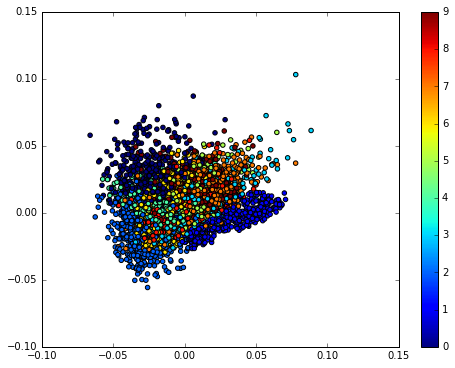

In [30]:
print "Illustrating latent dimension"

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)

with tf.Session() as sess:
    saver.restore(sess, "/tmp/mnist_seq2seq_vae.ckpt")
    print("Model restored.")
    
    examples_to_show = 5000
    x_sample, y_sample = mnist.test.next_batch(examples_to_show)
    x_sample = x_sample.reshape(examples_to_show,timestep,feature)
    z_mu = sess.run( z_logvar, feed_dict={x: x_sample, keep_prob: 1. })
    
    tsne_z_mu = model.fit_transform(z_mu)
    
    plt.figure(figsize=(8,6))
    plt.scatter( z_mu[:, 0], z_mu[:,1], c=np.argmax(y_sample,1) )
    plt.colorbar()


### Generating MNIST images

In [29]:
print "Generating Images"
with tf.Session() as sess:
    saver.restore(sess, "/tmp/mnist_seq2seq_vae.ckpt")
    print("Model restored.")
    
    nx = ny = 20
    x_values = np.linspace(-5, 5, nx)
    y_values = np.linspace(-5, 5, ny)

    canvas = np.empty((28*ny, 28*nx))
    for i, xi in enumerate(x_values):
        for j, yi in enumerate(y_values):
            z_mu = np.array([[xi,yi]])
            z_mu = np.tile(z_mu,(55,1))
            
            x_mean = sess.run( x_rec, feed_dict={z: z_mu, keep_prob : 1. })
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(10, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()

Generating Images
Model restored.


ValueError: Cannot feed value of shape (55, 2) for Tensor u'add_2:0', which has shape '(?, 10)'